In [22]:
import sqlite3
import pandas as pd
import struct
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Layer
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

### Vectorización de audio features

In [23]:
def load_data():
    """ Lee features de la base de datos features.db"""

    features_db_path = "dataset/features.db"
    genres_db_path = "dataset/genres.db"
    metadata_db_path = "dataset/metadata.db"
    tags_db_path = "dataset/tags.db"

    conn = sqlite3.connect(features_db_path)
    features_df = pd.read_sql_query("SELECT * FROM features", conn)
    conn.close()

    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    return features_df, genres_df, metadata_df, tags_df

features_df, genres_df, metadata_df, tags_df = load_data()

In [24]:
def decode_tempo(b):
    try:
        if isinstance(b, float):
            return b
        if isinstance(b, (bytes, bytearray)) and len(b) == 4:
            return struct.unpack('f', b)[0]  # <-- 'f' = float32 (4 bytes)
        if isinstance(b, str) and ',' in b:
            byte_list = list(map(int, b.split(',')))
            b = bytes(byte_list)
            return struct.unpack('f', b)[0]
    except Exception as e:
        print(f"⚠️ decode_tempo falló con {repr(b)}: {e}")
    return np.nan

def decode_array(b):
    try: 
        return np.frombuffer(b, dtype=np.float32)
    except Exception:
        return b

def concat_full_vector():
    """Concatena en un solo vector datos de features, genres y tags"""
    df = pd.concat([features_df, genres_df, tags_df], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True)
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        row_copy = row.drop(labels=['mfcc_mean', 'tempo', 'stft_mean', 'chroma_mean'], errors = "ignore").copy()
        other_features = row_copy.values.astype(np.float32)
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo, other_features])
        vectors.append(full_vector)
    return np.stack(vectors)

def concat_vector():
    """"Concatena en un solo vector datos de features solo"""
    df = features_df.copy()
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True) 
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo])
        vectors.append(full_vector)
    return np.stack(vectors)

vectors = concat_vector()
full_vectors = concat_full_vector()
print(vectors.shape)
print(vectors[0].shape)
print(full_vectors.shape)
print(full_vectors[0].shape)

(17783, 1051)
(1051,)
(17783, 1146)
(1146,)


### Normalización

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(vectors)
X_full = scaler.fit_transform(full_vectors)

In [26]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_full_train, X_full_test = train_test_split(X_full, test_size=0.2, random_state=42)

### Autoencoders

#### Autoencoder simple (AE)

In [27]:
def build_autoencoder(input_dim, latent_dim):
    """Construye un autoencoder simple"""
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    decoded = Dense(512, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

In [28]:
autoencoder, encoder = build_autoencoder(input_dim=X.shape[1], latent_dim=128)
print(encoder.summary())
tf.keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True, to_file='encoder.png', rankdir='LR' )

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       538,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,288 (2.31 MB)

 Trainable params: 604,288 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


In [29]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6262 - val_loss: 0.3796
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3613 - val_loss: 0.3185
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3020 - val_loss: 0.2737
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2738 - val_loss: 0.2398
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2275 - val_loss: 0.2206
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2177 - val_loss: 0.2144
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1831 - val_loss: 0.2010
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1843 - val_loss: 0.1965
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1710 - val_loss: 0.1792
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1568 - val_loss: 0.1692
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1509 - val_loss: 0.1722
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1427 - val

In [30]:
autoencoder_full, encoder_full = build_autoencoder(input_dim=X_full.shape[1], latent_dim=128)
autoencoder_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7531 - val_loss: 0.4327
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4455 - val_loss: 0.3723
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3667 - val_loss: 0.3217
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3170 - val_loss: 0.3046
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2904 - val_loss: 0.2823
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2690 - val_loss: 0.2675
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2525 - val_loss: 0.2487
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2286 - val_loss: 0.2418
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2165 - val_loss: 0.2290
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2003 - val_loss: 0.2158
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1972 - val_loss: 0.2075
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1

In [31]:
# Evaluación de los autoencoders
decoded_vectors = autoencoder.predict(X_test)
decoded_full_vectors = autoencoder_full.predict(X_full_test)
# MSE
mse_vectors = np.mean(np.power(X_test - decoded_vectors, 2), axis=1)
mse_full_vectors = np.mean(np.power(X_full_test - decoded_full_vectors, 2), axis=1)
# MAE
mae_vectors = np.mean(np.abs(X_test - decoded_vectors), axis=1)
mae_full_vectors = np.mean(np.abs(X_full_test - decoded_full_vectors), axis=1)
# RMSE
rmse_vectors = np.sqrt(mse_vectors)
rmse_full_vectors = np.sqrt(mse_full_vectors)
print(f"MSE: {mse_vectors.mean()} ± {mse_vectors.std()}")
print(f"RMSE: {rmse_vectors.mean()} ± {rmse_vectors.std()}")
print(f"MAE: {mae_vectors.mean()} ± {mae_vectors.std()} \n")

print(f"MSE full: {mse_full_vectors.mean()} ± {mse_full_vectors.std()}")
print(f"RMSE full: {rmse_full_vectors.mean()} ± {rmse_full_vectors.std()}")
print(f"MAE full: {mae_full_vectors.mean()} ± {mae_full_vectors.std()}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.09795283526182175 ± 0.48757171630859375
RMSE: 0.21947665512561798 ± 0.22312068939208984
MAE: 0.14656712114810944 ± 0.14580455422401428 

MSE full: 0.12615102529525757 ± 0.48652884364128113
RMSE full: 0.2763383686542511 ± 0.22313252091407776
MAE full: 0.17578718066215515 ± 0.14412006735801697


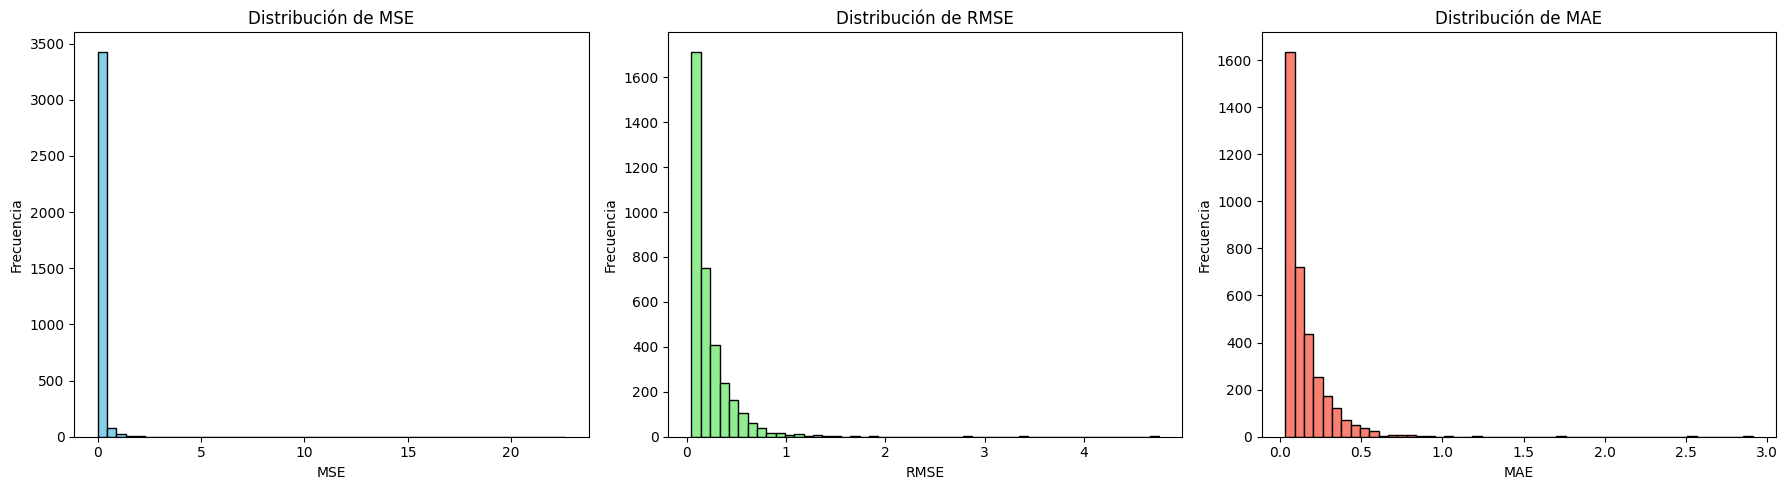

In [32]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(mse_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

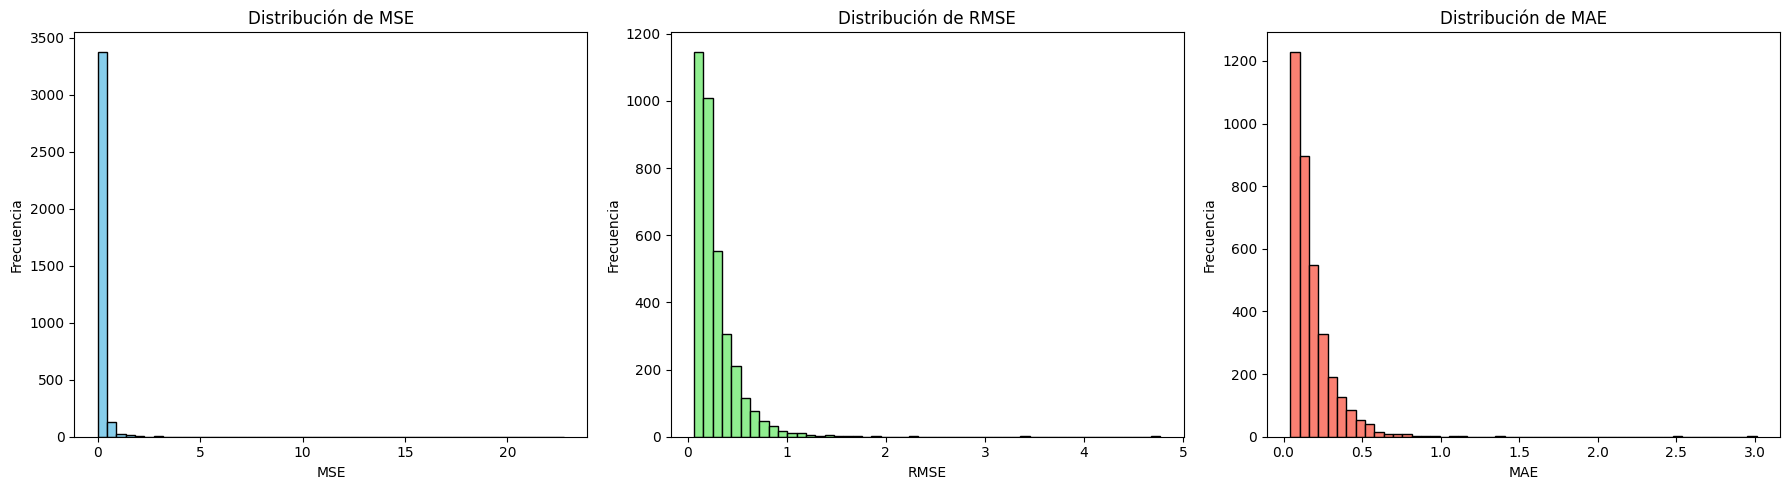

In [33]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(mse_full_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_full_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_full_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Se puede observar que para las tres distribuciones (MSE, RMSE, MAE), la mayoría de muestras tienen errores bajos, y solamente unas pocas tienen errores altos, lo que nos indica que son posibles outliers o ejemplos difíciles de reconstruir.

🟦 Distribución por MSE:
- Se ve un pico pronunciado cerca del 0, es decir, la mayoría de entradas se han reconstruído correctamente
- Tenemos unos cuantos ejemplos con MSE > 1 y algunos extremos que podrían ser anomalías o errores en la reconstrucción

🟩 Distribución de RMSE:
- Muy parecida al MSE
- La mayoría está por debajo de 0.5, lo que es un buen signo

🟥 Distribución de MAE:
- La mayoría de errores son bajos (0 - 0.2)
- Es menos sensible a errores extremos, pero también hay algunos ejemplos con MAE > 2

In [34]:
umbral_rmse = 1.0
outliers = np.where(rmse_vectors > umbral_rmse)[0]
print(f'{len(outliers)} muestras con RMSE > {umbral_rmse}')

39 muestras con RMSE > 1.0


#### Variational Autoencoder (VAE)

In [35]:
class Sampling(tf.keras.layers.Layer):
    """Clase de muestreo para el VAE"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = Input(shape=(input_dim,), name='encoder_input')
    encoded = Dense(512, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(encoded)
    z_log_var = Dense(latent_dim, name='z_log_var')(encoded)
    z = Sampling(name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    h_decoded = Dense(512, activation='relu')(latent_inputs)
    outputs = Dense(input_dim, activation='sigmoid')(h_decoded)
    
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE
    outputs = decoder(encoder(inputs)[2])  # Pasa z (muestreo) a través del decoder
    vae = Model(inputs, outputs, name='vae')

    return vae, encoder, decoder

# Pérdida de Reconstrucción (MSE o Binary Crossentropy)
def reconstruction_loss(x, x_decoded):
    return MeanSquaredError()(x, x_decoded)

# Pérdida KL
def kl_loss(z_mean, z_log_var):
    return -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

# Pérdida total (reconstrucción + KL)
def vae_loss(x, x_decoded, z_mean, z_log_var, beta=0.1):
    r_loss = reconstruction_loss(x, x_decoded)
    k_loss = kl_loss(z_mean, z_log_var)
    return r_loss +  k_loss

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [36]:
vae, vae_encoder, vae_decoder = build_vae(input_dim=X.shape[1], latent_dim=128)

vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

vae.summary()
vae.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test), callbacks=[early_stopping])

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 128), (None,   │       669,952 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1051)           │       605,211 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,163 (4.86 MB)

 Trainable params: 1,275,163 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 358647.7500 - val_loss: 8.4785
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2486 - val_loss: 2.5182
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3858 - val_loss: 1.8841
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7598 - val_loss: 1.7931
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5749 - val_loss: 1.7253
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5846 - val_loss: 1.5420
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4690 - val_loss: 1.4823
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4521 - val_loss: 1.3640
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2262 - val_loss: 1.3343
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2405 - val_loss: 1.3271
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2701 - val_loss: 1.3895
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss

In [37]:
vae_full, vae_encoder_full, vae_decoder_full = build_vae(input_dim=X_full.shape[1], latent_dim=128)
vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))
vae_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test), callbacks=[early_stopping])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 550.6636 - val_loss: 6.6303
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.5064 - val_loss: 2.7833
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3842 - val_loss: 2.1714
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8962 - val_loss: 1.7796
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7443 - val_loss: 1.7663
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5841 - val_loss: 1.7694
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5421 - val_loss: 1.5086
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4884 - val_loss: 1.5248
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4420 - val_loss: 1.5421
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4179 - val_loss: 1.5028
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3491 - val_loss: 1.3925
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1

Entrenamos finalmente nuestros autencoder con todo el dataset.

In [38]:
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)
encoded_vectors = encoder.predict(X)
autoencoder.save("models/autoencoder.keras")
encoder.save("models/encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0909
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0979
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1358
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1228
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1747
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1544
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1088
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0946
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1224
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0966
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0853
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0816
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0731
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0885
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1020
Epoch 16/50
70/70 ━

In [39]:
autoencoder_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
encoded_full_vectors = encoder_full.predict(X_full)
autoencoder_full.save("models/autoencoder_full.keras")
encoder_full.save("models/encoder_full.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1048
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1119
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1222
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1289
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1134
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1413
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1285
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1261
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1060
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1048
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0966
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0932
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0926
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0915
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0936
Epoch 16/50
70/70 ━

In [40]:
vae.fit(X, X, epochs=50, batch_size=256, shuffle=True)
vae_encoded_vectors = vae_encoder.predict(X, batch_size=32)
vae.save("models/vae.keras")
vae_encoder.save("models/vae_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2232
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1224
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0619
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0675
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0324
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2097
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0572
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1501
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0663
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0544
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0213
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9946
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0257
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0367
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0122
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [41]:
vae_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
vae_encoded_full_vectors = vae_encoder_full.predict(X_full, batch_size=32)
vae_full.save("models/vae_full.keras")
vae_encoder_full.save("models/vae_full_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0360
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0978
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0245
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0882
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9919
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0383
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0197
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9885
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0346
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0754
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0725
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0298
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0031
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0203
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0497
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [42]:
df_embeddings = pd.DataFrame({
    'clip_id': features_df['clip_id'].values,
    'original_embeddings': list(vectors),
    'encoded_embeddings': list(encoded_vectors),
    'original_full_embeddings': list(full_vectors),
    'encoded_full_embeddings': list(encoded_full_vectors),
    'vae_embeddings': list(vae_encoded_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
    'vae_full_embeddings': list(vae_encoded_full_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
})
df_embeddings.to_sql('embeddings', sqlite3.connect('dataset/embeddings.db'), if_exists='replace', index=False)

17783